Notebook to compute the eigenmode decomposition of 1D diffusion utilizing random walk methodology. Used to validate modal markov formulation for calcium diffusion. Simple 1d diffusion with no reactions.

10 nodes.

author: Margot Wagner
date created: 6/16/22

# 1D Diffusion Eigenmode Decomposition

In [9]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt

Define global variables

In [3]:
# create mesh
n_locs = 10               # define number of grid points along 1D line
dt = 1                    # time step (usec)
n_t_pts = 1000            # number of time points

start_loc = 4             # starting position for molecules
min_loc = 0               # minimum position
max_loc = n_locs - 1      # maximum position
last_elem_i = -1          # index for the last element in a list
move = 1                  # number of points a particle can move per timepoint

L = 4                     # total length of diffusion line (um)
N = 50                    # number of molecules
D = 2.20e-4               # Calcium diffusion coeff (um^2/usec)


### 1D Random Walk Diffusion Simulation

(implementation similar to GeeksforGeeks' ["Random Walk (Implementation in Python)"](https://www.geeksforgeeks.org/random-walk-implementation-python/))

In [18]:
def random_walk(N, n_t_pts, p):
    """ 1-D random walk for N molecules from a range of positions = [0, (n_locs - 1)]
    
    Args:
      N: 
        total number of molecules
      n_t_pts:
        number of time points
      p:
        probability of particle diffusing to neighboring grid point
u
    Returns:
      positions of all particles over time - matrix shaped (N, n_t_pts)
    """

    # probabilities depending on if particle is in middle or at edge
    p_middle = [p, 1 - 2*p, p]
    p_edge = [p, 1 - p]

    # initialize array for all particle positions
    all_N_positions = np.empty((N, n_t_pts), dtype='int64')

    for n in range(N):

        # Initialize starting position (0 to (n_locs - 1) range)
        positions = [start_loc]

        # sampling probability all at once (1000 timepoints) 
        r = np.random.random(n_t_pts - 1)

        # movement decision conditions
        move_l_cond = r < p
        move_r_cond = r > (1 - p)
        # stay condition is between the two

        # run simulation for particle n
        # check probability rolls 
        for move_left, move_right in zip(move_l_cond, move_r_cond):
        
            # if move_left is True and last position isn't the minimum position, move left
            left = move_left and positions[last_elem_i] > min_loc 

            # if move_right is True and last position isn't the maximum position, move right  
            right = move_right and positions[last_elem_i] < max_loc

            # stay condition is implied

            # adjust position accordingly 
            positions.append(positions[last_elem_i] - left + right)

        # add results to cumulative array
        all_N_positions[n] = positions
    
    return all_N_positions


* Calculate probability

In [19]:
def find_p(L, n_locs, D, dt):
    """ Find the probability of moving one spot to the left or right based on finite-difference approximations

    params:
        L:
            length of line on which molecule is diffusing
        n_locs:
            number of locations molecule can diffuse to
        D: 
            calcium diffusion constant
        dt: 
            time step 

    return:
        probability of diffusing one spot to the left or right

    """
    dx = L / n_locs         # distance of one "hop"
    k = D / dx**2             # rate constant

    return k*dt

* Find the number of particles at each node at each time point

In [20]:
def postprocess_rw(all_N_positions, plot=False):
    """Post-process 1D random-walk diffusion (counts, normalized counts, means)
    
    Args:
      all_N_positions: 
        positions of all particles over time - matrix shaped (N, n_t_pts)

    Returns:
      n_per_loc:
        number of particles in each position over time
      p_per_loc:
        number of particles normalized by N in each position over time
      means:
        mean value of particle number at each location over the whole simulation
    """

    # distribution of particles across positions over time
    n_per_loc = np.zeros((n_locs, n_t_pts), dtype='int64')      # number of particles over time
    p_per_loc = np.zeros((n_locs, n_t_pts))                     # normalized count over time

    for i in range(n_t_pts):
        # count number of particles in each position
        counts = np.bincount(all_N_positions[:,i])

        # resize to include all positions if it doesn't already
        counts.resize(n_locs)

        # assign number of particles
        n_per_loc[:, i] = counts

        # normalize counts and assign
        counts = counts / all_N_positions.shape[0]
        p_per_loc[:, i] = counts

    means = np.mean(n_per_loc, axis=1)

    if plot==True: 
      # plot particle counts for each position
      plt.figure(figsize=(14,10))

      for i in range(n_locs):
        plt.plot(list(range(n_t_pts)), p_per_loc[i, :])

      plt.title("Normalized number of particles in each position over time", fontsize=20)
      plt.xlabel("timepoint", fontsize=14)
      plt.ylabel("normalized count", fontsize=14)
      plt.legend(list(range(n_locs)))
      plt.show()

    return n_per_loc, p_per_loc, means

* Main

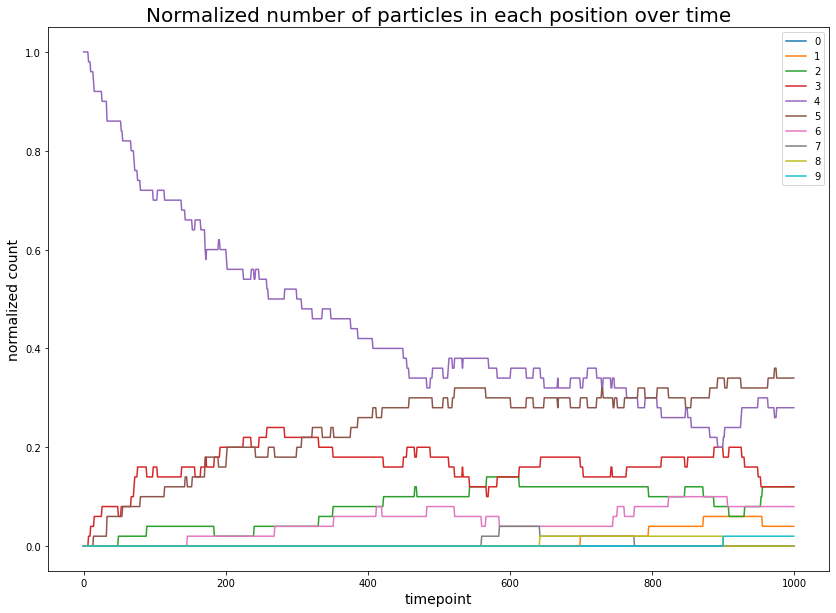

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.04 0.04 0.04]
 [0.   0.   0.   ... 0.12 0.12 0.12]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.02 0.02 0.02]]


In [22]:
def main():
    
    # find probability of moving one step 
    p = find_p(L, n_locs, D, dt)
    
    # run simulation
    all_N_positions = random_walk(N, n_t_pts, p)

    # plot output
    n_per_loc, p_per_loc, means = postprocess_rw(all_N_positions, plot=True)



if __name__ == '__main__':
    tables_created = main()     

### Solve for unknowns ($q_{+k}$ and $q_{-k}$)

For N = 1
\begin{equation} 
    q_{\pm k} = \frac{1}{2} \pm \frac{\sum_i p_i \text{v}_{i k}}{2\sqrt{\sum_i p_i (\text{v}_{i k})^2}} 
\end{equation}

In [26]:
# find probability of moving one step 
p = find_p(L, n_locs, D, dt)
    
# run simulation
all_N_positions = random_walk(N, n_t_pts, p)

# plot output
n_per_loc, p_per_loc, means = postprocess_rw(all_N_positions, plot=False)

print(p_per_loc)
print(p_per_loc.shape)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.04 0.04 0.04]
 [0.   0.   0.   ... 0.22 0.22 0.22]
 ...
 [0.   0.   0.   ... 0.02 0.02 0.02]
 [0.   0.   0.   ... 0.02 0.02 0.02]
 [0.   0.   0.   ... 0.   0.   0.  ]]
(10, 1000)


### Define transition matrix

* Where B is the dynamics matrix

In [30]:
# Define A (transition) matrix 
B = np.zeros((n_locs, n_locs))             # transition probability between grid points
vec_off_diag = np.full((n_locs - 1), p/dt)  # off-diagonal values

# create transition matrix
B = np.diag(vec_off_diag, k=1) + np.diag(vec_off_diag, k=-1)


print("B = \n", B)

B = 
 [[0.       0.001375 0.       0.       0.       0.       0.       0.
  0.       0.      ]
 [0.001375 0.       0.001375 0.       0.       0.       0.       0.
  0.       0.      ]
 [0.       0.001375 0.       0.001375 0.       0.       0.       0.
  0.       0.      ]
 [0.       0.       0.001375 0.       0.001375 0.       0.       0.
  0.       0.      ]
 [0.       0.       0.       0.001375 0.       0.001375 0.       0.
  0.       0.      ]
 [0.       0.       0.       0.       0.001375 0.       0.001375 0.
  0.       0.      ]
 [0.       0.       0.       0.       0.       0.001375 0.       0.001375
  0.       0.      ]
 [0.       0.       0.       0.       0.       0.       0.001375 0.
  0.001375 0.      ]
 [0.       0.       0.       0.       0.       0.       0.       0.001375
  0.       0.001375]
 [0.       0.       0.       0.       0.       0.       0.       0.
  0.001375 0.      ]]


* Where A is the probability matrix

In [31]:
# Define A (transition) matrix 
A = np.zeros((n_locs, n_locs))             # transition probability between grid points
vec_diag = np.full(n_locs, (1 - 2*p))         # diagonal values
vec_off_diag = np.full((n_locs - 1), (p))  # off-diagonal values

# create transition matrix
A = np.diag(vec_diag, k=0) + np.diag(vec_off_diag, k=1) + np.diag(vec_off_diag, k=-1)
A[0,0] = 1 - p
A[n_locs - 1, n_locs - 1] = 1 - p


print("A = \n", A)

A = 
 [[0.998625 0.001375 0.       0.       0.       0.       0.       0.
  0.       0.      ]
 [0.001375 0.99725  0.001375 0.       0.       0.       0.       0.
  0.       0.      ]
 [0.       0.001375 0.99725  0.001375 0.       0.       0.       0.
  0.       0.      ]
 [0.       0.       0.001375 0.99725  0.001375 0.       0.       0.
  0.       0.      ]
 [0.       0.       0.       0.001375 0.99725  0.001375 0.       0.
  0.       0.      ]
 [0.       0.       0.       0.       0.001375 0.99725  0.001375 0.
  0.       0.      ]
 [0.       0.       0.       0.       0.       0.001375 0.99725  0.001375
  0.       0.      ]
 [0.       0.       0.       0.       0.       0.       0.001375 0.99725
  0.001375 0.      ]
 [0.       0.       0.       0.       0.       0.       0.       0.001375
  0.99725  0.001375]
 [0.       0.       0.       0.       0.       0.       0.       0.
  0.001375 0.998625]]


### Find eigenvalues and vectors

In [37]:
e_val, e_vec = eig(A)
#print('Eigenvalues: \n', e_val)
#print('\nEigenvectors: \n', e_vec)

print('Numbe of eigenvalues: \t', len(e_val))
print('\nNumber of eigenvectors: \t', len(e_vec))
print('\nEigenvector length: \t', len(e_vec[0]))

Numbe of eigenvalues: 	 10

Number of eigenvectors: 	 10

Eigenvector length: 	 10


In [40]:
e_val_b, e_vec_b = eig(B)
#print('Eigenvalues: \n', e_val_b)
#print('\nEigenvectors: \n', e_vec_b)

print('Numbe of eigenvalues: \t', len(e_val_b))
print('\nNumber of eigenvectors: \t', len(e_vec_b))
print('\nEigenvector length: \t', len(e_vec_b[0]))

Numbe of eigenvalues: 	 10

Number of eigenvectors: 	 10

Eigenvector length: 	 10


Find $q_{\pm k}$

For N = 1
\begin{equation} 
    q_{\pm k} = \frac{1}{2} \pm \frac{\sum_i p_i \text{v}_{i k}}{2\sqrt{\sum_i p_i (\text{v}_{i k})^2}} 
\end{equation}

In [45]:
def q_pm_k(p, v):
    """ Find the normalized number of particles in the positive and negative state of eigenmode k

    params:
        p: 
            normalized number or particles at node i (vector)
        v:
            eigenvector of node i (vector); v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    
    return:
        q +- k
    """

    print(type(p))
    print(type(v))

    print(p.shape)
    print(v.shape)

    # multiply p[i, :] by v[:,i]
    print(p[0,:])
    print(v[:,0])



q_pm_k(p_per_loc, e_vec)

    

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(10, 1000)
(10, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [47]:
print(p_per_loc[5,:]) # at node 5, all timepoints
print(e_vec[:,5])     # all entries for the eigenvector associated with eigenvalue 5

# for mode = k (say k = 3)
# p_per_loc[i, n_t]
# e_vec[k, i]
print(e_vec[3, 5])



[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.02 0.02 0.02 0.02 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06
 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.08 0.08 0.08
 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.12 0.12 0.12 0.12 0.12
 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12
 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.1  0.1  0.1  0.1
 0.1  0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12
 0.12 0.12 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.16 0.16 0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0

In [ ]:
# want to sum across all i's
# ie p_per_loc[0,:]*e_vec[k, 0] + p_per_loc[1,:]*e_vec[k, 1] + p_per_loc[2,:]*e_vec[k, 2] ...

# denom is similar
# p_per_loc[0,:]*e_vec[k, 0]**2 + p_per_loc[1,:]*e_vec[k, 1]**2 + p_per_loc[2,:]*e_vec[k, 2]**2 ...

# This is doable!!

# p_per_loc[i, n_t]
# e_vec[k, i]
